In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sys
import json

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    
import twitter_credentials

In [2]:
class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
    def __init__(self):
        self._stopwords = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])
        
    def clean_tweet(self, tweet):
        tweet = tweet.lower() # convert text to lower-case
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) #url hilang
        tweet = re.sub('@[^\s]+', 'AT_USER', tweet) #ngilangin username
        tweet = re.sub(r'#([^\s]+)', r'\1', tweet) #remove hashtag
        tweet = word_tokenize(tweet) # (helloooooooo into hello)
        return ' '.join([word for word in tweet if word not in self._stopwords])

    def json_to_data_frame(self, anuFile):
        df = []
        for line in anuFile:
            try:
                j = json.loads(line.strip())
                # print (j['text'])
                df.append(j['text'])

            except:
                pass  # some tweets are malformed - we ignore them
        twit = pd.DataFrame(data=df, columns=['tweets'])
        return twit
    
    def sentimen_word2vec(self, tweet):
        # build vocabulary and train model
        model = gensim.models.Word2Vec(tweet,size=150,window=10,min_count=2,workers=10,iter=10)
        return model.wv.most_similar(positive=tweet,topn=5)
    
    def sentimen_vader(self, tweet_bersih):
        analyzzer = SentimentIntensityAnalyzer()
        score = analyzzer.polarity_scores(tweet_bersih)
        return "{}".format(score['compound'])
    
    def labeling(self, sentimen):
        if sentimen == 0:
            lb = 'netral'
        elif sentimen < 0:
            lb = 'negatif'
        elif sentimen > 0:
            lb = 'positif'
        return lb
        

In [3]:
def bacaFile(filenya):
    namaFile = filenya
    # print (f"nama file {namaFile}")
    with open(namaFile, 'rb') as f:
        isiFile = f.readlines()
    return isiFile

In [4]:
# if __name__ == '__main__':
tweet_analyzer = TweetAnalyzer()
tweets = bacaFile('daftarTweets.txt')
df = tweet_analyzer.json_to_data_frame(tweets)

In [5]:
print(df['tweets'].head(10))

0    RT @ShobhaBJP: Horrific visuals from the land ...
1    RT @EveningStandard: Lions nap peacefully on S...
2    @ImranKhanPTI @MJALSHRIKA This is the #Hindu #...
3    RT @HLN_BE: Zuid-Korea versoepelt lockdown bee...
4    I was supposed to have my first cum bukkake ne...
5    RT @KChiruTweets: On a Sunday before lockdown....
6    RT @tanwer_m: This is from Jehanabad, Bihar. \...
7    RT @DavidLammy: Number 10 should urgently expl...
8    RT @kendrahunsley: me to my friends after lock...
9    "What are you looking forward to once lockdown...
Name: tweets, dtype: object


In [6]:
#bersihin tweet
df['tweets'] = np.array([tweet_analyzer.clean_tweet(tweet) for tweet in df['tweets']])
#sentimen analisis
df['sentiment'] = np.array([float(tweet_analyzer.sentimen_vader(tweet)) for tweet in df['tweets']])
df['label'] = np.array([tweet_analyzer.labeling(tweet) for tweet in df['sentiment']])
print(df.head(10))

                                              tweets  sentiment    label
0  rt horrific visuals land shivajimaharaj hindu ...    -0.7964  negatif
1  rt lions nap peacefully south africa roads cor...     0.5267  positif
2  hindu sindhi pakistan ready commit suicide chi...    -0.2023  negatif
3           rt zuid-korea versoepelt lockdown beetje     0.0000   netral
4  supposed first cum bukkake next week lockdown ...    -0.4767  negatif
5  rt sunday lockdown missing meeting dear ones s...     0.8074  positif
6  rt jehanabad bihar kids surging lockdown eatin...     0.0000   netral
7  rt number 10 urgently explain boris johnson re...    -0.3182  negatif
8                                rt friends lockdown     0.4767  positif
9  `` looking forward lockdown '' people seeing f...     0.4767  positif


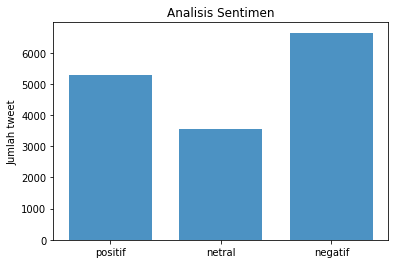

In [7]:
pos = len(df[df.sentiment > 0])
neg = len(df[df.sentiment < 0])
net = len(df[df.sentiment == 0])

y = [pos, neg, net]
plt.title('Analisis Sentimen')
plt.ylabel('Jumlah tweet')
plt.xticks(range(len(y)), ['positif', 'netral', 'negatif'])
plt.bar(range(len(y)), height=y, width=0.75, align='center', alpha=0.8)
plt.show()

In [8]:
len(df)

15494

In [9]:
df.isnull().sum()

tweets       0
sentiment    0
label        0
dtype: int64

In [10]:
df['label'].unique()

array(['negatif', 'positif', 'netral'], dtype=object)

In [11]:
df['label'].value_counts()

netral     6646
positif    5284
negatif    3564
Name: label, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
X = df['tweets']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
X_test.shape

(4649,)

In [28]:
X_train.shape

(10845,)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Naïve Bayes:
text_clf_nb = Pipeline([('tfidfn', TfidfVectorizer()),
                     ('clfn', MultinomialNB()),
])

# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

In [21]:
text_clf_lsvc.fit(X_train,y_train)
# text_clf_nb.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [22]:
predictions = text_clf_lsvc.predict(X_test)

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [24]:
print(confusion_matrix(y_test,predictions))

[[ 866  109   95]
 [  60 1835  108]
 [  55  164 1357]]


In [25]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

     negatif       0.88      0.81      0.84      1070
      netral       0.87      0.92      0.89      2003
     positif       0.87      0.86      0.87      1576

    accuracy                           0.87      4649
   macro avg       0.87      0.86      0.87      4649
weighted avg       0.87      0.87      0.87      4649



In [26]:
print(accuracy_score(y_test, predictions))

0.8728758872875887
